In [1]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from PIL import Image
import re
import functools
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
df = pd.read_csv('weather.csv')

df


Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

In [3]:
df = pd.read_csv('weather.csv').dropna(subset=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']).reset_index(drop=True)

date = {value: datetime.strptime(value, '%Y-%m-%d').timetuple().tm_yday for value in df['Date'].unique()}
location = {value: index for index, value in enumerate(df['Location'].unique())}
wind_direction_max = {value: index for index, value in enumerate(df['WindGustDir'].unique())}
wind_direction_9am = {value: index for index, value in enumerate(df['WindDir9am'].unique())}
wind_direction_3pm = {value: index for index, value in enumerate(df['WindDir3pm'].unique())}

df['Date'] = df['Date'].map(lambda value: date[value])
df['Location'] = df['Location'].map(lambda value: location[value])
df['WindGustDir'] = df['WindGustDir'].map(lambda value: wind_direction_max[value])
df['WindDir9am'] = df['WindDir9am'].map(lambda value: wind_direction_9am[value])
df['WindDir3pm'] = df['WindDir3pm'].map(lambda value: wind_direction_3pm[value])
df['RainToday'] = df['RainToday'].map(lambda value: 0 if value == 'No' else 1)
df['RainTomorrow'] = df['RainTomorrow'].map(lambda value: 0 if value == 'No' else 1)

df.fillna(df.mean(), inplace = True)

df

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        336         0     13.4     22.9       0.6     5.609501  7.718384   
1        337         0      7.4     25.1       0.0     5.609501  7.718384   
2        338         0     12.9     25.7       0.0     5.609501  7.718384   
3        339         0      9.2     28.0       0.0     5.609501  7.718384   
4        340         0     17.5     32.3       1.0     5.609501  7.718384   
...      ...       ...      ...      ...       ...          ...       ...   
123705   171        46      3.5     21.8       0.0     5.609501  7.718384   
123706   172        46      2.8     23.4       0.0     5.609501  7.718384   
123707   173        46      3.6     25.3       0.0     5.609501  7.718384   
123708   174        46      5.4     26.9       0.0     5.609501  7.718384   
123709   175        46      7.8     27.0       0.0     5.609501  7.718384   

        WindGustDir  WindGustSpeed  WindDir9am  ...  Humidity9am  Humidity3pm  \
0                 0           44.0           0  ...         71.0         22.0   
1                 1           44.0           1  ...         44.0         25.0   
2                 2           46.0           0  ...         38.0         30.0   
3                 3           24.0           2  ...         45.0         16.0   
4                 0           41.0           3  ...         82.0         33.0   
...             ...            ...         ...  ...          ...          ...   
123705           14           31.0          11  ...         59.0         27.0   
123706           14           31.0           2  ...         51.0         24.0   
123707            4           22.0           2  ...         56.0         21.0   
123708            5           37.0           2  ...         53.0         24.0   
123709           12           28.0           5  ...         51.0         24.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1  8.000000  4.491408     16.9     21.8   
1            1010.6       1007.8  4.407404  4.491408     17.2     24.3   
2            1007.6       1008.7  4.407404  2.000000     21.0     23.2   
3            1017.6       1012.8  4.407404  4.491408     18.1     26.5   
4            1010.8       1006.0  7.000000  8.000000     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
123705       1024.7       1021.2  4.407404  4.491408      9.4     20.9   
123706       1024.6       1020.3  4.407404  4.491408     10.1     22.4   
123707       1023.5       1019.1  4.407404  4.491408     10.9     24.5   
123708       1021.0       1016.8  4.407404  4.491408     12.5     26.1   
123709       1019.4       1016.5  3.000000  2.000000     15.1     26.0   

        RainToday  RainTomorrow  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  
...           ...           ...  
123705          0             0  
123706          0             0  
123707          0             0  
123708          0             0  
123709          0             0  

[123710 rows x 23 columns]

In [4]:
x = df
y = x.pop('RainTomorrow')

x_scaled = StandardScaler().fit_transform(x)


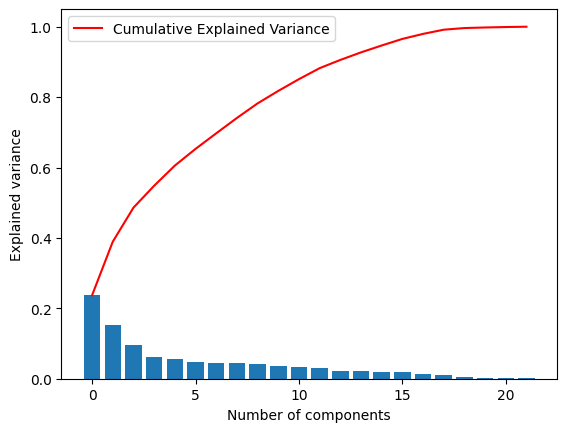

In [5]:
pca = PCA()
pca.fit_transform(x_scaled)

plt.bar(
    range(0, len(pca.explained_variance_ratio_)),
    pca.explained_variance_ratio_
)

plt.plot(
    range(0, len(pca.explained_variance_ratio_)),
    np.cumsum(pca.explained_variance_ratio_),
    c = 'red',
    label = 'Cumulative Explained Variance'
)

plt.legend(loc = 'upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

plt.show()

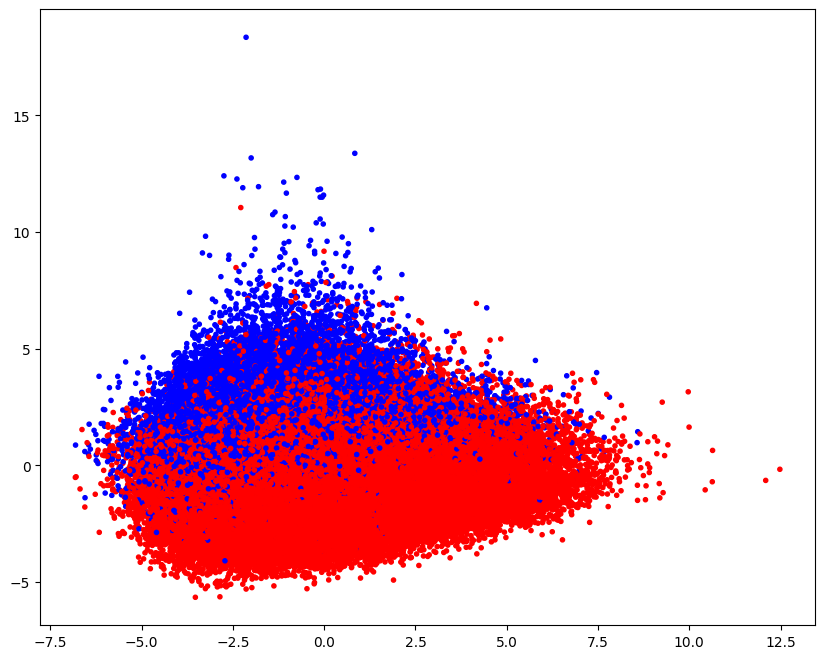

In [6]:
x_two_dimensional = PCA(n_components = 2).fit_transform(x_scaled)
colors=['red' if dot == 0 else 'blue' for dot in y]

fig = plt.figure(figsize=(10, 8))
plt.scatter(x_two_dimensional[:, 0], x_two_dimensional[:, 1], color = colors, marker = '.')
plt.show()


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_two_dimensional, y, test_size=0.25)

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')


Accuracy score: 0.7981764097258148


In [8]:
unique_test, counts_test = np.unique(y_test, return_counts = True)
unique_pred, counts_pred = np.unique(y_pred, return_counts = True)

pd.DataFrame.from_records([
	dict(zip(unique_test, counts_test)),
	dict(zip(unique_pred, counts_pred))
], index = ['test', 'pred'])


0     1
test  24075  6853
pred  25927  5001

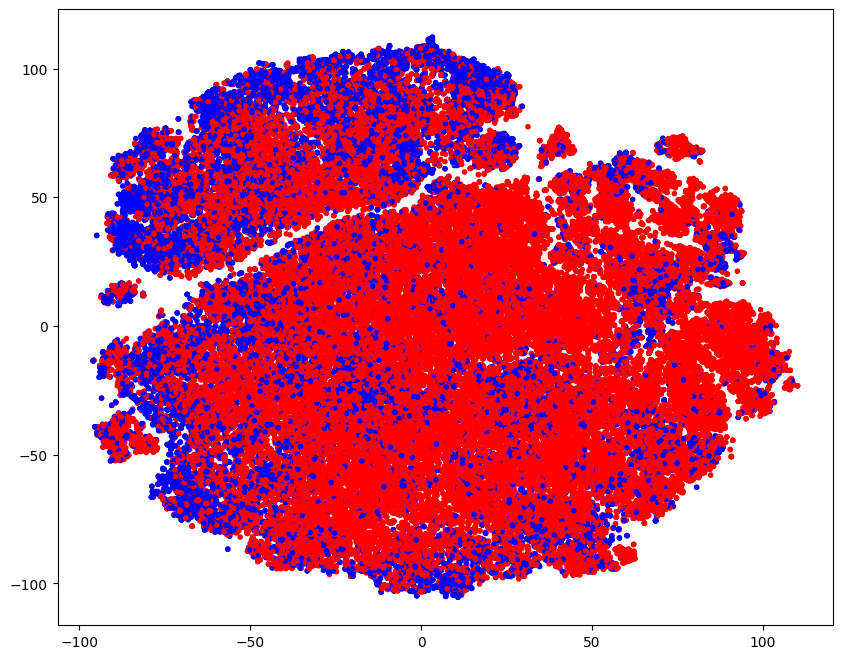

In [9]:
x_two_dimensional = TSNE(n_components = 2, verbose = 0).fit_transform(x_scaled)
colors=['red' if dot == 0 else 'blue' for dot in y]

fig = plt.figure(figsize=(10, 8))
plt.scatter(x_two_dimensional[:, 0], x_two_dimensional[:, 1], color = colors, marker = '.')
plt.show()

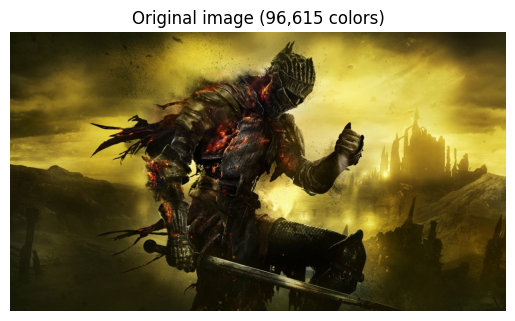

In [10]:
image = np.array(Image.open('./image.jpg'), dtype=np.float64) / 255

w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(image)


In [11]:
def quantize_image(n_colors):
	image_array_sample = shuffle(image_array, random_state = 0, n_samples = 1_000)
	code_book_k_means = KMeans(n_clusters = n_colors, n_init = "auto", random_state = 0).fit(image_array_sample)
	labels_k_means = code_book_k_means.predict(image_array)
	
	code_book_random = shuffle(image_array, random_state = 0, n_samples = n_colors)
	labels_random = pairwise_distances_argmin(code_book_random, image_array, axis = 0)

	return (code_book_k_means.cluster_centers_, labels_k_means, code_book_random, labels_random)

def recreate_image(code_book, labels, w, h):
    return code_book[labels].reshape(w, h, -1)


In [12]:
def cluster_analysis(n_colors):
	code_book_k_means, labels_k_means, code_book_random, labels_random = quantize_image(n_colors)

	fig, ax = plt.subplots(figsize = (20, 20))

	plt.subplot(1, 2, 1)
	plt.axis("off")
	plt.title(f"Quantized image ({n_colors} colors, K-Means)")
	plt.imshow(recreate_image(code_book_k_means, labels_k_means, w, h))

	plt.subplot(1, 2, 2)
	plt.axis("off")
	plt.title(f"Quantized image ({n_colors} colors, Random)")
	plt.imshow(recreate_image(code_book_random, labels_random, w, h))


C:\Users\o.halitsa\AppData\Local\Temp\ipykernel_56332\622773302.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


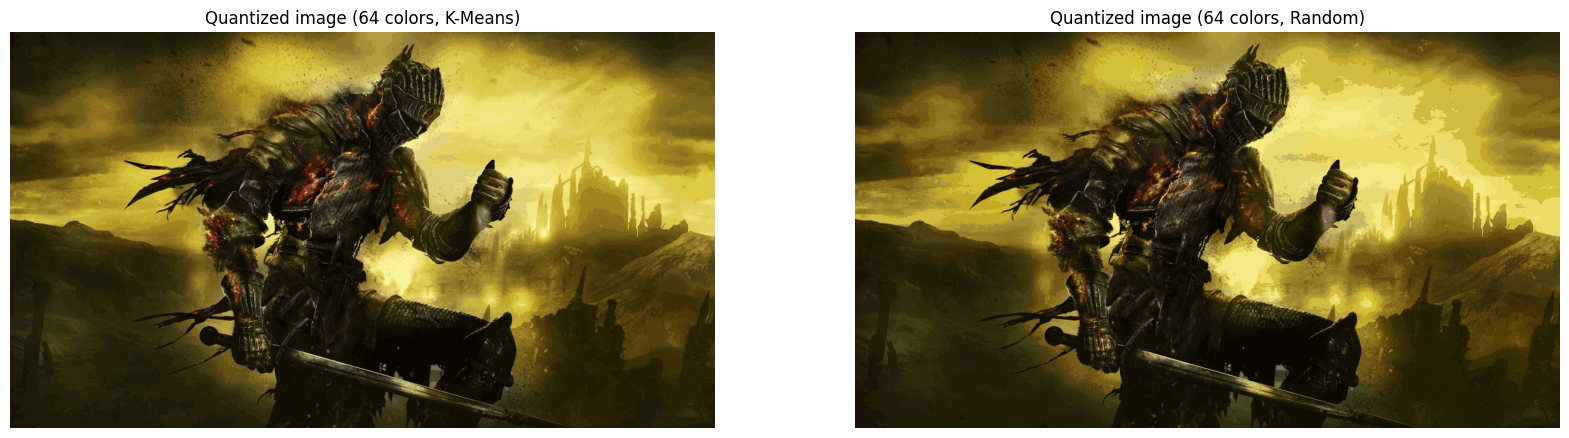

In [13]:
cluster_analysis(64)


C:\Users\o.halitsa\AppData\Local\Temp\ipykernel_56332\622773302.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


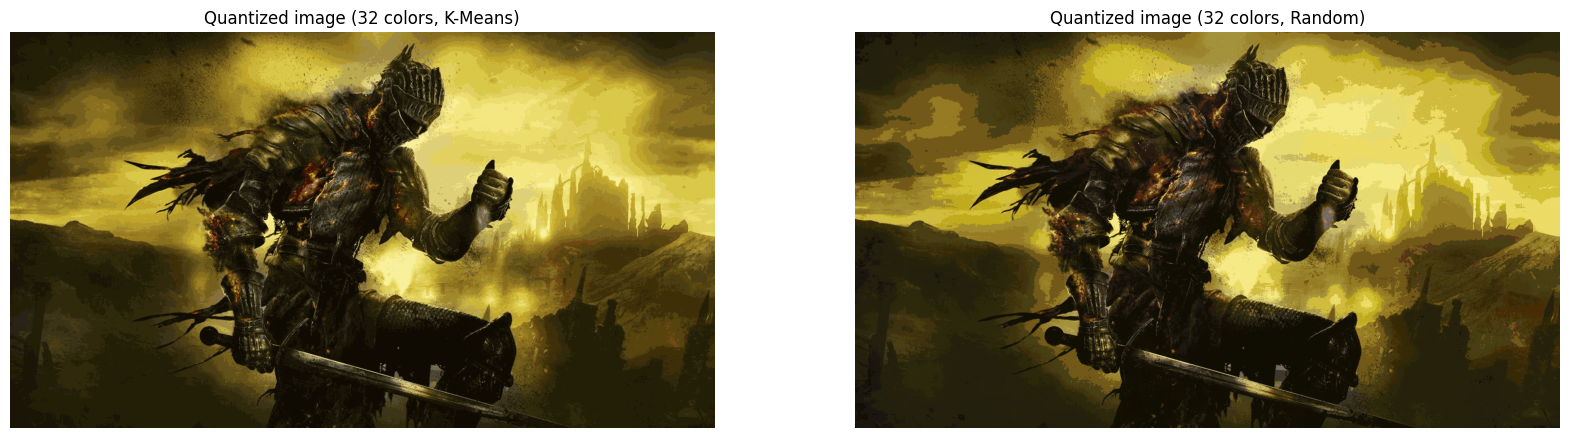

In [14]:
cluster_analysis(32)


C:\Users\o.halitsa\AppData\Local\Temp\ipykernel_56332\622773302.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


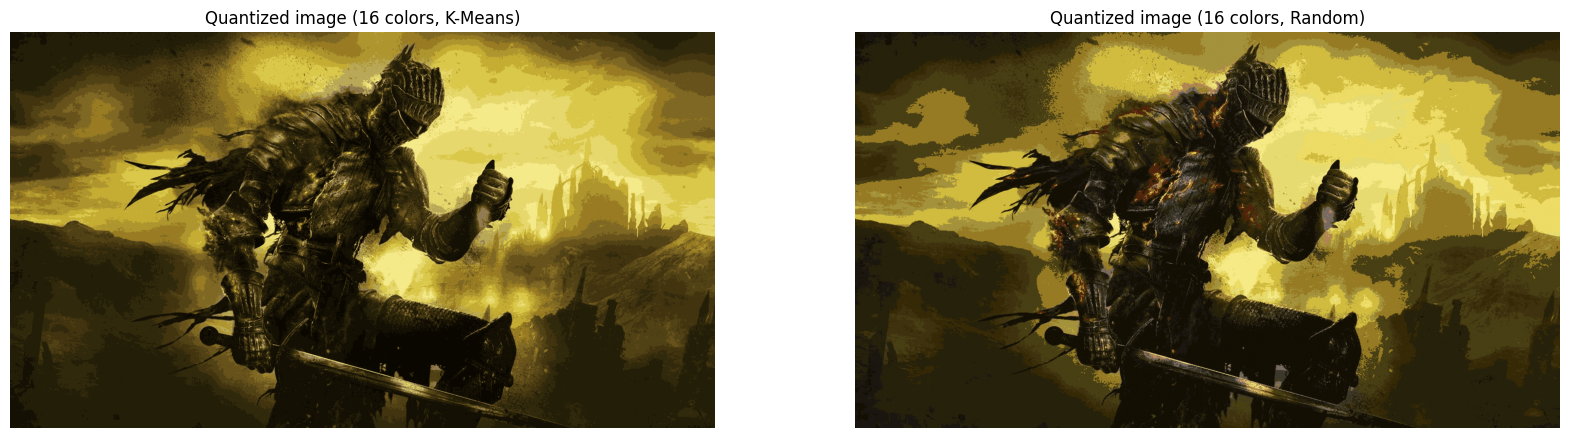

In [15]:
cluster_analysis(16)


C:\Users\o.halitsa\AppData\Local\Temp\ipykernel_56332\622773302.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


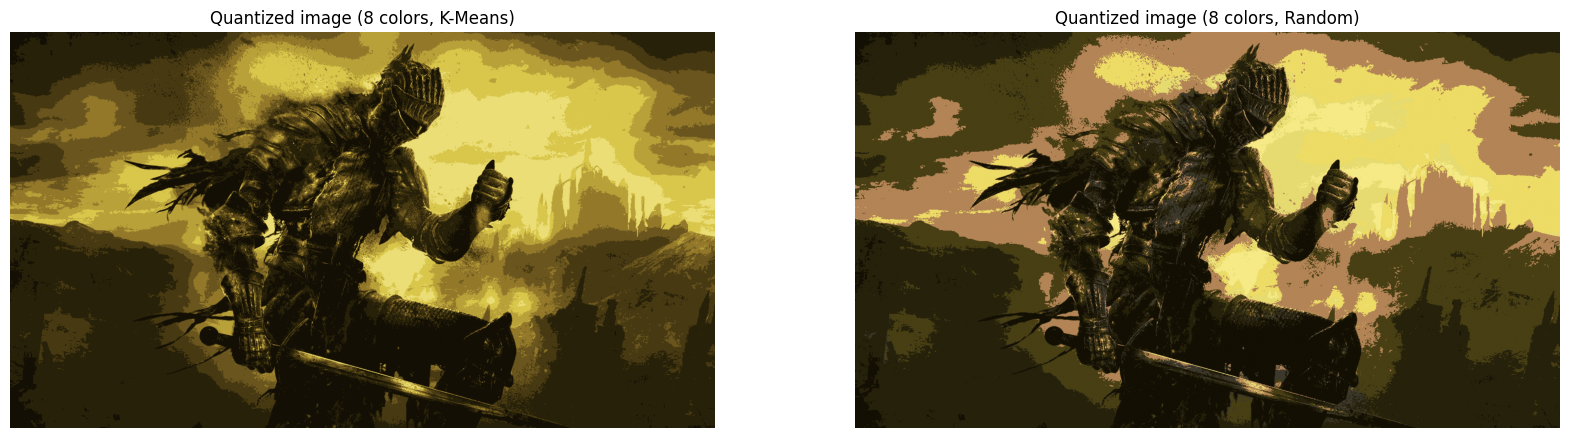

In [16]:
cluster_analysis(8)


In [17]:
# source of dataset: https://www.kaggle.com/datasets/algord/fake-news
df = pd.read_csv('./fake-news.csv').dropna().reset_index(drop = True)

print(df['real'].value_counts())

df

1    17371
0     5495
Name: real, dtype: int64


title  \
0      Kandi Burruss Explodes Over Rape Accusation on...   
1      People's Choice Awards 2018: The best red carp...   
2      Sophia Bush Sends Sweet Birthday Message to 'O...   
3      Colombian singer Maluma sparks rumours of inap...   
4      Gossip Girl 10 Years Later: How Upper East Sid...   
...                                                  ...   
22861  Pippa Middleton wedding: In case you missed it...   
22862  Zayn Malik & Gigi Hadid’s Shocking Split: Why ...   
22863  Jessica Chastain Recalls the Moment Her Mother...   
22864  Tristan Thompson Feels "Dumped" After Khloé Ka...   
22865  Kelly Clarkson Performs a Medley of Kendrick L...   

                                                news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
22861  https://www.express.co.uk/news/royal/807049/pi...   
22862  hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...   
22863  http://www.justjared.com/2018/01/17/jessica-ch...   
22864  www.intouchweekly.com/posts/tristan-thompson-f...   
22865  https://www.billboard.com/articles/news/bbma/8...   

               source_domain  tweet_num  real  
0                 toofab.com         42     1  
1              www.today.com          0     1  
2           www.etonline.com         63     1  
3        www.dailymail.co.uk         20     1  
4            www.zerchoo.com         38     1  
...                      ...        ...   ...  
22861      www.express.co.uk         52     1  
22862      hollywoodlife.com          7     0  
22863      www.justjared.com         26     1  
22864  www.intouchweekly.com         24     0  
22865      www.billboard.com         85     1  

[22866 rows x 5 columns]

In [18]:
stop_words = set(stopwords.words('english'))

def clean_message(message):
	cleaned_message = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|http.+?', '', message.lower())

	return functools.reduce(lambda acc, word: f'{acc} {word}' if word not in stop_words else acc, cleaned_message.split(' '))


In [19]:
df['title'] = df['title'].map(clean_message)

df

title  \
0      kandi burruss explodes rape accusation real ho...   
1       peoples choice awards 2018 best red carpet looks   
2      sophia bush sends sweet birthday message one t...   
3      colombian singer maluma sparks rumours inappro...   
4      gossip girl 10 years later upper east siders s...   
...                                                  ...   
22861  pippa middleton wedding case missed itpippa ma...   
22862  zayn malik  gigi hadids shocking split theres ...   
22863  jessica chastain recalls moment mothers boyfri...   
22864  tristan thompson feels dumped khlo kardashian ...   
22865  kelly clarkson performs medley kendrick lamars...   

                                                news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
22861  https://www.express.co.uk/news/royal/807049/pi...   
22862  hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...   
22863  http://www.justjared.com/2018/01/17/jessica-ch...   
22864  www.intouchweekly.com/posts/tristan-thompson-f...   
22865  https://www.billboard.com/articles/news/bbma/8...   

               source_domain  tweet_num  real  
0                 toofab.com         42     1  
1              www.today.com          0     1  
2           www.etonline.com         63     1  
3        www.dailymail.co.uk         20     1  
4            www.zerchoo.com         38     1  
...                      ...        ...   ...  
22861      www.express.co.uk         52     1  
22862      hollywoodlife.com          7     0  
22863      www.justjared.com         26     1  
22864  www.intouchweekly.com         24     0  
22865      www.billboard.com         85     1  

[22866 rows x 5 columns]

C:\Users\o.halitsa\AppData\Local\Temp\ipykernel_56332\2020442200.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


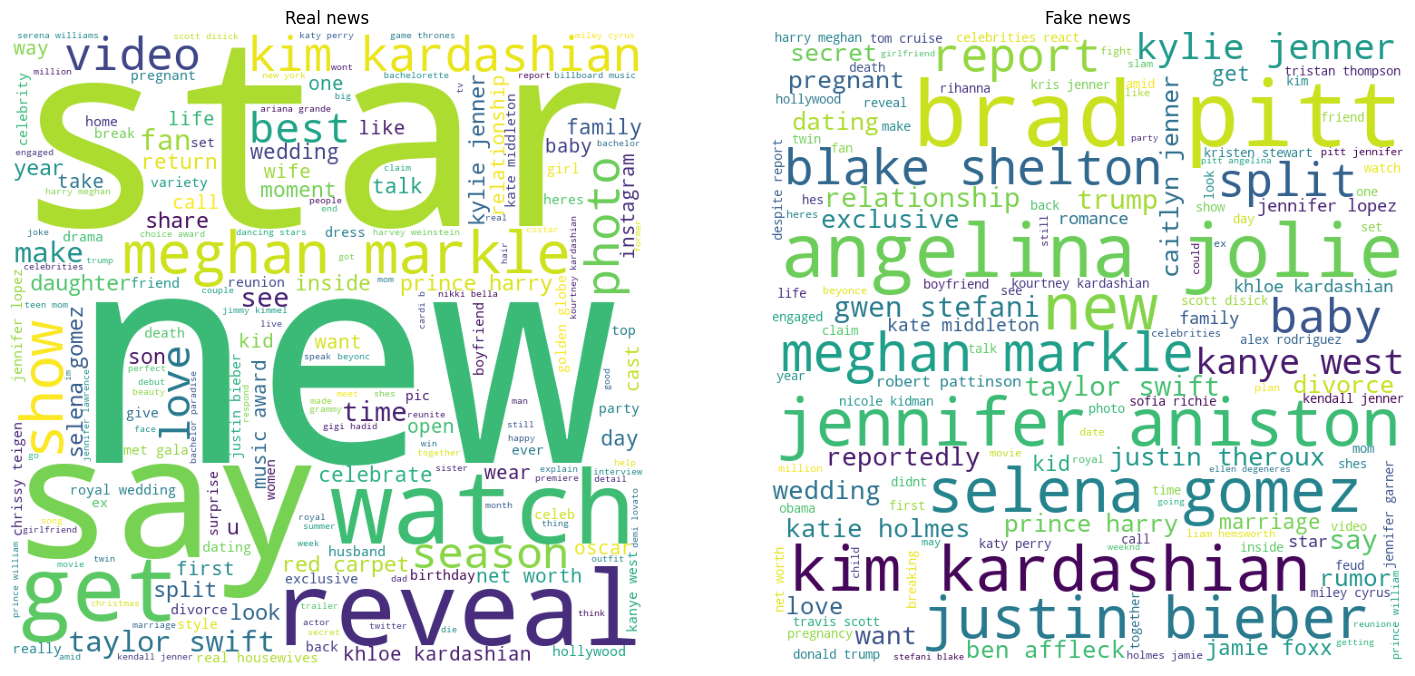

In [20]:
fig, ax = plt.subplots(figsize = (18, 18))

plt.subplot(1, 2, 1)

real_news = df[df['real'] == 1]

word_cloud_real = WordCloud(
	width = 700,
	height = 700,
    background_color ='white',
    stopwords = stop_words,
    min_font_size = 10
).generate(functools.reduce(lambda text, sentence: f'{text} {sentence}', list(real_news['title'])))

plt.axis("off")
plt.title(f'Real news')
plt.imshow(word_cloud_real)

plt.subplot(1, 2, 2)

fake_news = df[df['real'] == 0]

word_cloud_fake = WordCloud(
	width = 700,
	height = 700,
    background_color ='white',
    stopwords = stop_words,
    min_font_size = 10
).generate(functools.reduce(lambda text, sentence: f'{text} {sentence}', list(fake_news['title'])))

plt.axis("off")
plt.title(f'Fake news')
plt.imshow(word_cloud_fake)


In [21]:
x = df['title']
y = df['real']


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


In [23]:
vectorizer = TfidfVectorizer()
x_train_transformed = vectorizer.fit_transform(x_train)
x_test_transformed = vectorizer.transform(x_test)


In [24]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(x_train_transformed, y_train)

y_pred = random_forest.predict(x_test_transformed)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')


Accuracy score: 0.836977435718034


In [25]:
unique_test, counts_test = np.unique(y_test, return_counts = True)
unique_pred, counts_pred = np.unique(y_pred, return_counts = True)

pd.DataFrame.from_records([
	dict(zip(unique_test, counts_test)),
	dict(zip(unique_pred, counts_pred))
], index = ['test', 'pred'])


0     1
test  1331  4386
pred   953  4764